In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from multiprocess import Pool

## Datos

In [2]:
BASE_PATH = "/media/giani/Gianicosas/Magister/"

In [3]:
playlists = pd.read_csv(f'{BASE_PATH}100000_spotify_sample.csv.gz')

tracks = pd.read_csv(f'{BASE_PATH}100000_tracks_sample.csv.gz')
tracks.columns = tracks.columns.str.replace('audio_features.', '')

artistas = pd.read_csv(f'{BASE_PATH}100000_artist_sample.csv.gz')
artistas.columns = artistas.columns.str.replace('artists.', '')

/home/giani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/home/giani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


## Pre procesamiento

### Selección de características

In [4]:
playlists_sel = playlists[[
    'name', 'collaborative', 'pid', 'num_tracks', 'num_albums', 'num_artists', 'pos', 'track_uri', 'artist_uri', 'track_name', 'album_name'
]].dropna().drop_duplicates().rename(columns={
    "name": "playlist_name"
})

# Se selecciona las canciones de menos de 10 minutos de duración
tracks_sel = tracks[tracks["duration_ms"] / 60000 < 10][[
    "uri", "energy", "danceability", "acousticness", "valence"
]].dropna().drop_duplicates().rename(columns={
    "uri": "track_uri"
})

artistas_sel = artistas[[
    "uri", "name", "genres"
]].dropna().drop_duplicates().rename(columns={
    "uri": "artist_uri",
    "name": "artist_name"
})

## Procesamiento Track Features

In [37]:
tracks_comps = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(tracks_sel.drop(columns="track_uri")))
tracks_sel["track_comp_1"] = tracks_comps[:, 0]
tracks_sel["track_comp_2"] = tracks_comps[:, 1]

### Procesamiento Género

In [6]:
artistas_sel['genres'] = [
  eval(g)
  for g in tqdm(artistas_sel['genres'], total=artistas_sel.shape[0])
]

artistas_sel = artistas_sel.explode('genres')
artistas_sel.shape

  0%|          | 0/109603 [00:00<?, ?it/s]

(196778, 3)

In [7]:
vc = artistas_sel["genres"].value_counts()
generos_sels = vc[vc > 10].index # Se selecciona los generos presentes en al menos 10 artistas
artistas_sel = artistas_sel[artistas_sel["genres"].isin(generos_sels)] # se selecciona los artistas con los generos seleccionados
artistas_sel.shape

(140057, 3)

### Generación de matriz de atributos

In [40]:
df = pd.merge(
    artistas_sel.rename(columns={
        "genres": "genre"
    }),
    pd.merge(
        playlists_sel,
        tracks_sel[["track_uri", "track_comp_1", "track_comp_2"]],
        how="inner"
    ),
    how="inner"
)

df = df[df["genre"].isin(df["genre"].value_counts().head(20).index)] # 1000 generos mas frecuentes

playlists_sel.shape, tracks_sel.shape, artistas_sel.shape, df.shape

((6626860, 11), (682561, 7), (140057, 3), (11412669, 15))

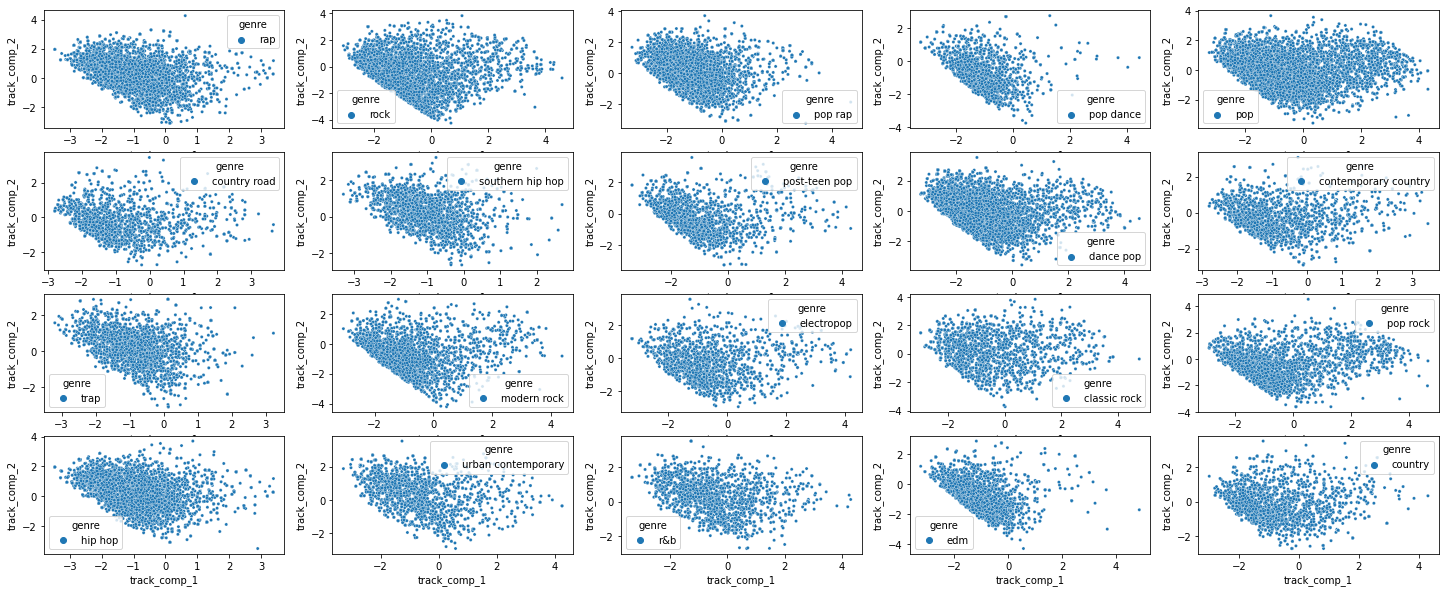

In [41]:
plt.figure(figsize=(25,10))
t = df.sample(100000, random_state=42)

for i, g in enumerate(t["genre"].unique()):
    plt.subplot(t["genre"].nunique() // 5, 5, i + 1)
    sns.scatterplot(x="track_comp_1", y="track_comp_2", hue="genre", data=t[t["genre"] == g], s=10);

In [42]:
df.groupby("genre")["track_comp_1"].describe().sort_values(by=["mean"]).style.background_gradient(cmap="Blues")

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
pop rap,924108.000000,-0.995904,0.947578,-3.605329,-1.641585,-1.122290,-0.480442,5.364051
southern hip hop,417459.000000,-0.974210,0.855067,-3.605329,-1.550744,-1.006722,-0.449619,4.677786
pop dance,300472.000000,-0.968651,0.795215,-3.373878,-1.474331,-0.992267,-0.512052,5.308162
dance pop,1107583.000000,-0.962215,1.144268,-3.462011,-1.771159,-1.139655,-0.395611,5.551845
post-teen pop,353212.000000,-0.949655,1.219362,-3.597690,-1.820036,-1.181694,-0.336370,5.343748
edm,376163.000000,-0.900211,0.866665,-3.373878,-1.462450,-0.955207,-0.441993,5.308162
hip hop,865753.000000,-0.893473,0.976210,-3.605329,-1.584350,-0.953442,-0.313648,5.255033
rap,1078966.000000,-0.860340,0.936459,-3.605329,-1.513369,-0.929151,-0.286347,4.895409
trap,528253.000000,-0.843236,0.857831,-3.605329,-1.390297,-0.896227,-0.331969,4.677786
